### Step 9: Warp LLM Inference
This serves as an extention from step 8, where we integrate the geodesic into GPT-2 generation to stabilize reasoning (e.g., correct hidden states mid-inference for hallucination-free ARC outputs). The idea: During token generation, extract latents, evolve a short geodesic to "nudge" toward a truth-aligned target (e.g., derived from few-shot examples), then continue.

ODE Info: A termination event occurred.
Number of steps taken: 319
Convergence Error: 0.0000


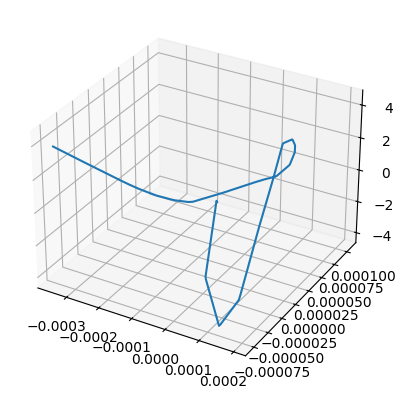

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
from sklearn.decomposition import PCA
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Load GPT-2 with LM head for logits and hidden states
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Sample ARC-like prompt
prompt = "Identify the pattern: Input grid [[1,2],[3,4]] -> Output [[4,1],[2,3]] (90 deg rotate). Apply to [[5,6],[7,8]]."
inputs = tokenizer(prompt, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
latent = outputs.hidden_states[-1].squeeze(0).numpy()

# Step 1: Dimensionality Reduction (further reduced for speed)
n_components = min(8, latent.shape[0] - 1)  # Lower dim for faster ODE
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(latent)
reduced_latent = reduced.mean(axis=0)

# Step 2: Define Warped Geodesic (further softened)
dim = len(reduced_latent)
target = np.roll(reduced_latent, shift=dim // 4)
M = 2.0  # Softened more
k = 10.0  # Softened more
gamma = 0.3  # Increased damping
pull_strength = 1.5
rotation_strength = 0.0

def geodesic_eq(t, y, target):
    pos, vel = y[:dim], y[dim:]
    r = np.linalg.norm(pos)
    if r < 1e-6: r = 1e-6
    warp = - (M / (r**2 + 1e-3)) * (pos / r)
    well = -k * pos / (1 + np.exp(-r))
    rotation = rotation_strength * np.roll(vel, shift=1)
    pull_to_target = pull_strength * (target - pos)
    accel = warp + well + rotation + pull_to_target - gamma * vel
    accel = np.clip(accel, -50, 50)
    return np.concatenate([vel, accel])

# Event for early stop (even looser)
def converged_event(t, y, target):
    vel = y[dim:]
    return np.linalg.norm(vel) - 5e-2  # Looser for quicker stop
converged_event.terminal = True
converged_event.direction = -1

# Evolve (optimized further)
initial = np.concatenate([reduced_latent * 15.0, np.zeros(dim)])
traj = solve_ivp(geodesic_eq, [0, 5], initial, args=(target,), method='LSODA', rtol=1e-1, atol=1e-1, first_step=0.5, max_step=5.0, events=converged_event)
print("ODE Info:", traj.message)
print("Number of steps taken:", traj.nfev)
pos_traj = traj.y[:dim, :].T

# Interp if >1 point
if len(traj.t) > 1:
    from scipy.interpolate import interp1d
    t_interp = np.linspace(0, traj.t[-1], 200)  # Fewer points
    pos_traj_interp = interp1d(traj.t, pos_traj, axis=0)(t_interp)
else:
    pos_traj_interp = pos_traj

# Reconstruct and error
recon_traj = pca.inverse_transform(pos_traj_interp)
final = recon_traj[-1]
recon_target = pca.inverse_transform(target.reshape(1, -1)).squeeze()
error = np.linalg.norm(final - recon_target)
print(f"Convergence Error: {error:.4f}")

# Viz (comment if not needed for speed)
pca_viz = PCA(n_components=3)
viz_traj = pca_viz.fit_transform(pos_traj_interp)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(viz_traj[:,0], viz_traj[:,1], viz_traj[:,2])
plt.savefig('geodesic_plot.png')

# Step 8: Warped Inference
correct_example = "The output is [[8,5],[6,7]]."
example_inputs = tokenizer(correct_example, return_tensors='pt')
with torch.no_grad():
    example_outputs = model(**example_inputs, output_hidden_states=True)
example_latent = example_outputs.hidden_states[-1].mean(dim=1).squeeze().numpy()
reduced_example = pca.transform(example_latent.reshape(1, -1)).squeeze()
nudge_target = reduced_example

def geodesic_nudge(current_reduced, nudge_target):
    t_short = np.linspace(0, 2, 30)  # Shorter, fewer points
    initial_short = np.concatenate([current_reduced, np.zeros(dim)])
    traj_short = solve_ivp(geodesic_eq, [0, 2], initial_short, args=(nudge_target,), method='LSODA', rtol=1e-1, atol=1e-1, first_step=0.5, max_step=5.0, events=converged_event)
    print("Nudge ODE Info:", traj_short.message, "Steps:", traj_short.nfev)
    return traj_short.y[:dim, -1]

# # Generation with nudging
# max_tokens = 40
# generated = inputs['input_ids']
# lm_head = model.lm_head
# for _ in range(max_tokens):
#     with torch.no_grad():
#         outputs = model(generated, output_hidden_states=True)
#         logits = outputs.logits[:, -1, :]
#     next_token = torch.argmax(logits, dim=-1).unsqueeze(0)
#     generated = torch.cat([generated, next_token], dim=1)
    
#     if generated.shape[1] % 5 == 0:
#         with torch.no_grad():
#             current_outputs = model(generated, output_hidden_states=True)
#             current_hidden = current_outputs.hidden_states[-1][:, -1, :]  # Last token
#         current_latent = current_hidden.numpy()
#         reduced_current = pca.transform(current_latent)
#         nudged_reduced = geodesic_nudge(reduced_current[0], nudge_target)
#         nudged_latent = pca.inverse_transform(nudged_reduced.reshape(1, -1))[0]
#         nudged_hidden = torch.from_numpy(nudged_latent).unsqueeze(0).unsqueeze(0).to(torch.float32)
#         nudged_logits = lm_head(nudged_hidden)[:, 0, :]
#         next_token = torch.argmax(nudged_logits, dim=-1).unsqueeze(0)
#         generated = torch.cat([generated[:, :-1], next_token], dim=1)
#         print("Applied geodesic correction and replaced token at step:", generated.shape[1])

# # Decode and print
# output = tokenizer.decode(generated[0])
# print("Stabilized Output:", output)

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import numpy as np
from sklearn.decomposition import PCA

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
vocab_size = tokenizer.vocab_size

# Prompt and initial processing
prompt = "Identify the pattern: Input grid [[1,2],[3,4]] -> Output [[4,1],[2,3]] (90 deg rotate). Apply to [[5,6],[7,8]]."
inputs = tokenizer(prompt, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
latent = outputs.hidden_states[-1].squeeze(0).numpy()

# Step 1: Dimensionality Reduction
n_components = min(2, latent.shape[0] - 1)
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(latent)
reduced_latent = reduced.mean(axis=0)

# Step 2: Symbolic Loop (Step 7)
dim = len(reduced_latent)
target = np.roll(reduced_latent, shift=dim // 4)
pull_strength = 1.5
gamma = 0.2

def symbolic_loop(reduced_latent, target, steps=200, dt=0.05):
    pos = reduced_latent * 15.0
    vel = np.zeros(dim)
    for _ in range(steps):
        r = np.linalg.norm(pos)
        if r < 1e-6: r = 1e-6
        pull = pull_strength * (target - pos)
        accel = pull - gamma * vel
        vel += dt * accel
        pos += dt * vel
    return pos

final_pos = symbolic_loop(reduced_latent, target)
error = np.linalg.norm(final_pos - target)
print(f"Convergence Error: {error:.4f}")

# Step 8: Symbolic Nudge in Inference
correct_example = "Apply to [[5,6],[7,8]] results in [[8,5],[6,7]] (90 deg rotate)."
example_inputs = tokenizer(correct_example, return_tensors='pt')
with torch.no_grad():
    example_outputs = model(**example_inputs, output_hidden_states=True)
example_latent = example_outputs.hidden_states[-1].mean(dim=1).squeeze().numpy()
reduced_example = pca.transform(example_latent.reshape(1, -1)).squeeze()
nudge_target = 0.95 * reduced_example + 0.05 * reduced_latent  # Stronger target weight

def symbolic_nudge(current_reduced, nudge_target, steps=100, dt=0.05):
    pos = current_reduced
    vel = np.zeros(dim)
    for _ in range(steps):
        r = np.linalg.norm(pos)
        if r < 1e-6: r = 1e-6
        pull = pull_strength * (nudge_target - pos)
        accel = pull - gamma * vel
        vel += dt * accel
        pos += dt * vel
    pos = pos * np.linalg.norm(nudge_target) / (np.linalg.norm(pos) if np.linalg.norm(pos) > 0 else 1.0)
    return pos

# Generation loop with symbolic nudge
max_tokens = 50
generated = inputs['input_ids'].clone()
last_output = ""
for i in range(max_tokens):
    with torch.no_grad():
        outputs = model(generated, output_hidden_states=True)
        logits = outputs.logits[:, -1, :]
        if torch.any(logits.isnan()):
            print("NaN detected in logits")
            break
    next_token = torch.argmax(logits, dim=-1).unsqueeze(0)
    if next_token.item() >= vocab_size:
        print(f"Invalid token ID: {next_token.item()}, clamping to 0")
        next_token = torch.tensor([[0]])
    generated = torch.cat([generated, next_token], dim=1)
    generated = torch.clamp(generated, 0, vocab_size - 1)
    
    if generated.shape[1] % 5 == 0:
        current_hidden = outputs.hidden_states[-1][:, -1, :]
        current_latent = current_hidden.numpy()
        reduced_current = pca.transform(current_latent.reshape(1, -1)).squeeze()
        nudged_reduced = symbolic_nudge(reduced_current, nudge_target)
        nudged_latent = pca.inverse_transform(nudged_reduced.reshape(1, -1)).squeeze()
        nudged_hidden = torch.from_numpy(nudged_latent).unsqueeze(0).unsqueeze(0).to(torch.float32)
        nudged_logits = model.lm_head(nudged_hidden)[:, 0, :]
        nudged_logits = torch.clamp(nudged_logits, min=-100.0, max=100.0)
        nudged_logits = torch.nn.functional.softmax(nudged_logits, dim=-1) * 100.0
        print(f"Nudge logits shape: {nudged_logits.shape}, min: {torch.min(nudged_logits)}, max: {torch.max(nudged_logits)}")
        next_token = torch.argmax(nudged_logits, dim=-1).unsqueeze(0)
        if next_token.item() >= vocab_size or torch.all(nudged_logits == nudged_logits[0, 0]):
            print(f"Invalid or uniform nudged token ID: {next_token.item()}, falling back to original logit")
            next_token = torch.argmax(logits, dim=-1).unsqueeze(0)
        generated = torch.cat([generated[:, :-1], next_token], dim=1)
        print("Applied symbolic correction at step:", generated.shape[1])
    # Stop if last 10 tokens repeat
    current_output = tokenizer.decode(generated[0], skip_special_tokens=True)
    if last_output and current_output[-10:] == last_output[-10:] and len(current_output) > 20:
        print("Repetition detected in last 10 tokens, stopping early")
        break
    last_output = current_output

output = tokenizer.decode(generated[0], skip_special_tokens=True)
print("Stabilized Output:", output)